In [1]:
%%capture
!pip install neptune-client psutil
!git clone https://github.com/Cho-D-YoungRae/URP_PD.git
%cd URP_PD

In [23]:
import dataset
import object_detection
from utils import *

import os
import argparse
from PIL import Image
import numpy as np
import json

from torchvision.transforms import functional as TF
from torch.nn.functional import interpolate
import torch
import torchvision.transforms

data_dir = '/content/drive/MyDrive/2021.summer_URP/PD/KAIST_PD'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using <{device}> device")

Using <cuda> device


In [8]:
# ====== constants ======#
label_map = {'background': 0, 'person': 1}
rev_label_map = {v: k for k, v in label_map.items()} 

## setting

In [12]:
from torch.backends import cudnn
import random

cudnn.benchmark = True

# ====== Random Seed Initialization ====== #
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.baselineID = 20

# ====== Dataset ====== #
args.ch_option = {'num_ch': 1,
                  'img_type': 'lwir',
                  'one_ch_option': 'mean'}
args.val_split = 0.1

# ====== Model ====== #
args.base_model = 'VGG16bnBase'
args.n_classes = len(label_map)
args.is_sds = True
args.usages_seg_feats = [True, True, True, False, False, False]


# ====== Optimizer & Training ====== #
args.optim = 'Adam'
args.lr = 5e-4
args.twice_b_lr = True
args.weight_decay = 5e-4

args.epochs = 100
args.train_batch_size = 32
args.test_batch_size = 64

args.decay_lr_at = [int(args.epochs/6)*4,
                    int(args.epochs/6)*5]
args.decay_lr_to = 0.1

In [33]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
if args.ch_option.get('num_ch') == 1:
    if args.ch_option.get('one_ch_option') == 'mean':
        mean = sum(mean) / len(mean)
        std = sum(std) / len(std)

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(300,300)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

In [34]:
checkpoint_dir = '/content/drive/MyDrive/2021.summer_URP/PD/checkpoint'
checkpoint_path = os.path.join(checkpoint_dir,
                               str(args.baselineID)+'.pth.tar')

checkpoint = torch.load(checkpoint_path)
save_epoch = checkpoint['epoch']
print(f'Loaded checkpoint from epoch {save_epoch}\n')
model = checkpoint['model']
model = model.train()

Loaded checkpoint from epoch 100



## Segmentation performance

In [21]:
img_id = 'set08/V001/I02119'
ann_path = os.path.join(data_dir, 'annotation_json', img_id+'.json')
img_dir, img_name = os.path.split(img_id)
img_path = os.path.join(data_dir, 'images', img_dir, 'lwir', img_name+'.jpg')

In [24]:
with open(ann_path, 'r') as j:
    anns = json.load(j)

In [25]:
anns

{'annotation': [{'bbox': [593, 221, 625, 295],
   'category_id': 1,
   'id': 0,
   'image_id': 2119,
   'is_crowd': 0},
  {'bbox': [424, 220, 468, 271],
   'category_id': -1,
   'id': 1,
   'image_id': 2119,
   'is_crowd': 0},
  {'bbox': [398, 223, 422, 268],
   'category_id': 1,
   'id': 2,
   'image_id': 2119,
   'is_crowd': 0},
  {'bbox': [53, 210, 79, 263],
   'category_id': 1,
   'id': 3,
   'image_id': 2119,
   'is_crowd': 0},
  {'bbox': [473, 220, 496, 269],
   'category_id': 1,
   'id': 4,
   'image_id': 2119,
   'is_crowd': 0},
  {'bbox': [504, 220, 523, 267],
   'category_id': 1,
   'id': 5,
   'image_id': 2119,
   'is_crowd': 0},
  {'bbox': [517, 221, 534, 257],
   'category_id': 1,
   'id': 6,
   'image_id': 2119,
   'is_crowd': 0}],
 'image': {'file_name': 'I02119', 'height': 512, 'id': 2119, 'width': 640}}

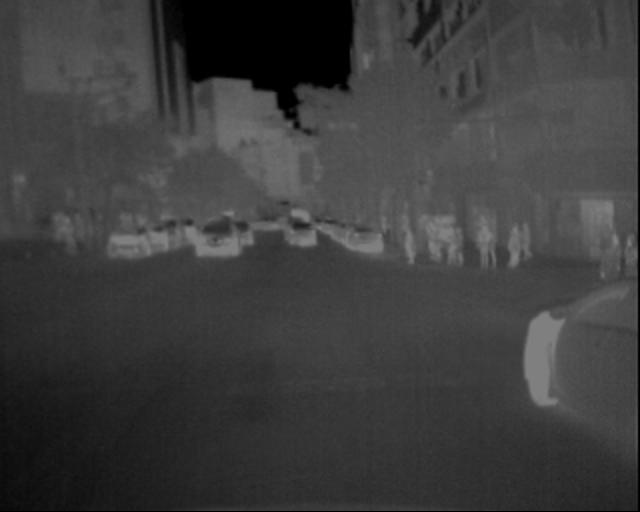

In [38]:
image = Image.open(img_path).convert('L')
image

In [29]:
img_size = (image.height, image.width)
pseudo_gt = torch.zeros(img_size)
for ann in anns['annotation']:
    x_min, y_min, x_max, y_max = ann['bbox']
    pseudo_gt[y_min:y_max+1, x_min:x_max+1] = 1

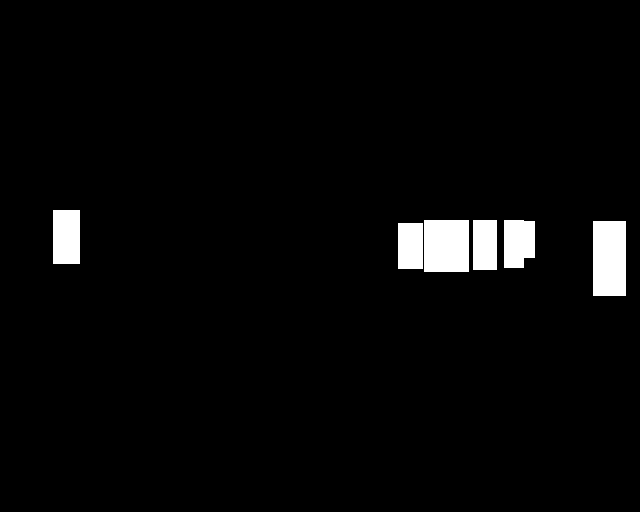

In [30]:
TF.to_pil_image(pseudo_gt)

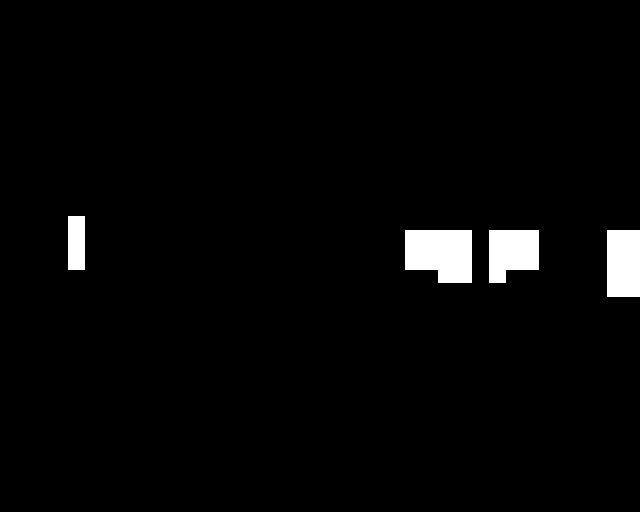

In [31]:
down_size = (38, 38)
down_gt = interpolate(pseudo_gt.unsqueeze(0).unsqueeze(0), size=down_size)
down_gt = interpolate(down_gt, size=img_size)
TF.to_pil_image(down_gt[0][0])

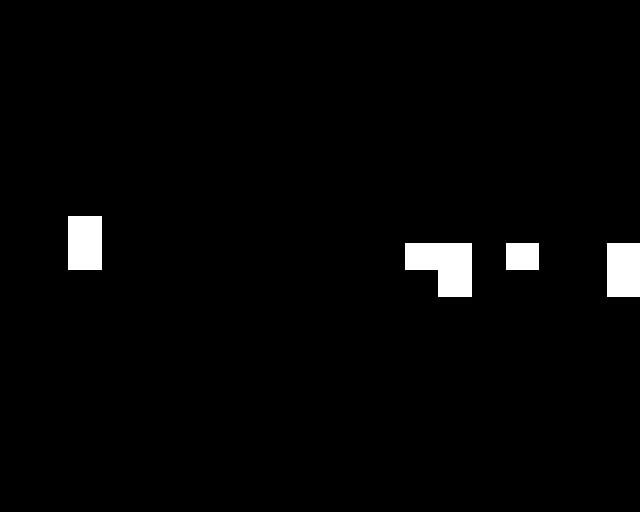

In [35]:
down_size = (19, 19)
down_gt = interpolate(pseudo_gt.unsqueeze(0).unsqueeze(0), size=down_size)
down_gt = interpolate(down_gt, size=img_size)
TF.to_pil_image(down_gt[0][0])

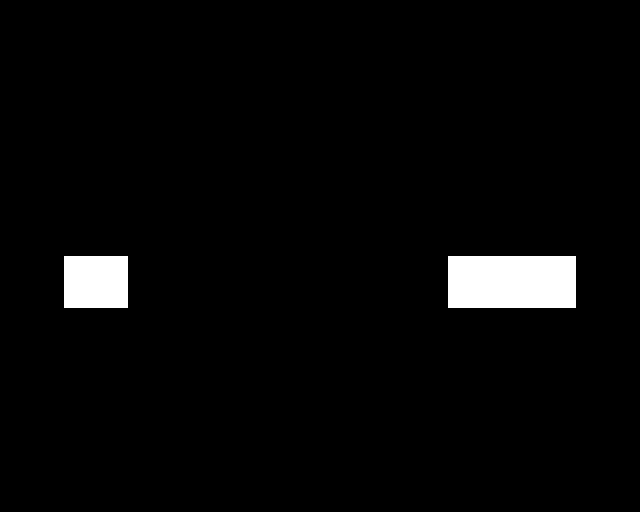

In [36]:
down_size = (10, 10)
down_gt = interpolate(pseudo_gt.unsqueeze(0).unsqueeze(0), size=down_size)
down_gt = interpolate(down_gt, size=img_size)
TF.to_pil_image(down_gt[0][0])

In [40]:
input = preprocess(image).to(device)
predicted_locs, predicted_scores, segmentations = model(input.unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


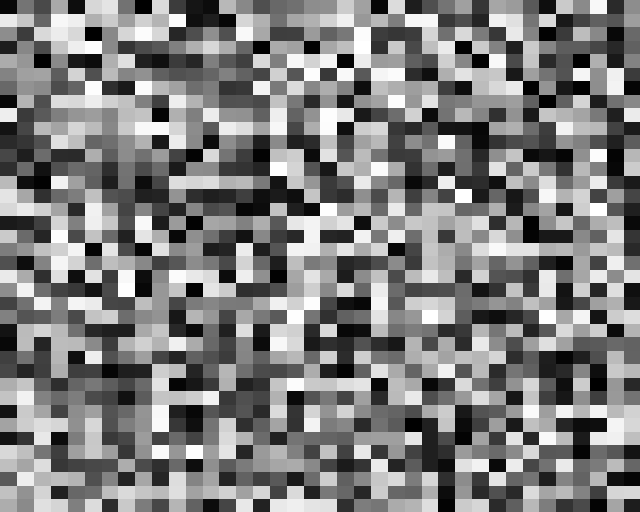

In [50]:
segmentation = segmentations[0]
segmentation = interpolate(segmentation, size=img_size)
TF.to_pil_image(segmentation[0][1])

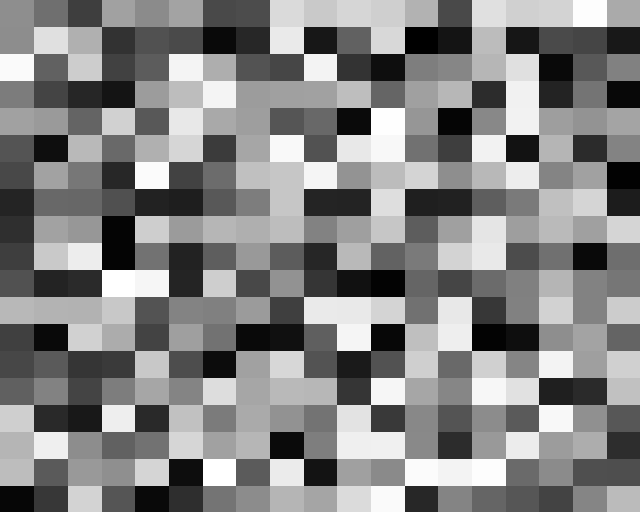

In [47]:
segmentation = segmentations[1]
segmentation = interpolate(segmentation, size=img_size)
TF.to_pil_image(segmentation[0][1])

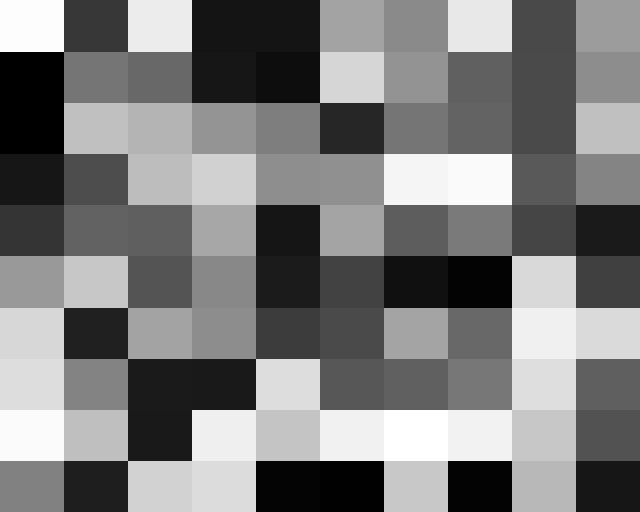

In [48]:
segmentation = segmentations[2]
segmentation = interpolate(segmentation, size=img_size)
TF.to_pil_image(segmentation[0][1])